<a href="https://colab.research.google.com/github/Dhananjay-Ghosh/ensemble-pretrained-models/blob/main/ensemble_pretrained_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/Dhananjay-Ghosh/ensemble-pretrained-models.git

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
fatal: could not create work tree dir 'ensemble-pretrained-models': No such file or directory


In [ ]:
!ls

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory


In [ ]:
!mv download.png /content/ensemble-pretrained-models

In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od

In [ ]:
dataset_url = 'https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000'

In [ ]:
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: dhananjayghosh1234
Your Kaggle Key: ··········


100%|██████████| 5.20G/5.20G [00:44<00:00, 126MB/s]


In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil

# Load the dataset metadata
data_dir = './skin-cancer-mnist-ham10000'
metadata_path = os.path.join(data_dir, 'HAM10000_metadata.csv')
metadata = pd.read_csv(metadata_path)

# Create directories for training and validation sets
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)

# Split the data into train and validation
train_df, val_df = train_test_split(metadata, test_size=0.2, random_state=42, stratify=metadata['dx'])

# Function to copy images to train/validation directories
def arrange_images(dataframe, target_dir):
    for _, row in dataframe.iterrows():
        img_filename = row['image_id'] + '.jpg'
        label_dir = os.path.join(target_dir, row['dx'])
        os.makedirs(label_dir, exist_ok=True)
        src = os.path.join(data_dir, 'HAM10000_images_part_1', img_filename)
        if not os.path.exists(src):
            src = os.path.join(data_dir, 'HAM10000_images_part_2', img_filename)
        dst = os.path.join(label_dir, img_filename)
        shutil.copy(src, dst)

# Arrange the images into their respective directories
arrange_images(train_df, train_dir)
arrange_images(val_df, validation_dir)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input  # VGG16-specific preprocessing
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

Found 8012 images belonging to 7 classes.
Found 2003 images belonging to 7 classes.


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16

# Load VGG16 pre-trained on ImageNet without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Create and compile the model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/10
250/250 [==============================] - 187s 701ms/step - loss: 1.2083 - accuracy: 0.6516 - val_loss: 0.9363 - val_accuracy: 0.6754
Epoch 2/10
250/250 [==============================] - 170s 678ms/step - loss: 1.0748 - accuracy: 0.6685 - val_loss: 0.9487 - val_accuracy: 0.6694
Epoch 3/10
250/250 [==============================] - 167s 668ms/step - loss: 1.0430 - accuracy: 0.6688 - val_loss: 0.9288 - val_accuracy: 0.6683
Epoch 4/10
250/250 [==============================] - 164s 657ms/step - loss: 1.0142 - accuracy: 0.6694 - val_loss: 0.9276 - val_accuracy: 0.6699
Epoch 5/10
250/250 [==============================] - 168s 672ms/step - loss: 0.9989 - accuracy: 0.6689 - val_loss: 0.8953 - val_accuracy: 0.6678
Epoch 6/10
250/250 [==============================] - 165s 660ms/step - loss: 0.9959 - accuracy: 0.6693 - val_loss: 0.9079 - val_accuracy: 0.6704
Epoch 7/10
250/250 [==============================] - 164s 657ms/step - loss: 0.9730 - accuracy: 0.6698 - val_loss: 0.8856 -

In [ ]:
model.save('vgg16_ham10000_trained.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.save('vgg16_ham10000_trained.keras')

In [ ]:
from tensorflow.keras.applications import VGG16, DenseNet121, MobileNetV2
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.models import Model

def build_model(base_model, num_classes):
    # Freeze layers in the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Adding custom Layers
    x = base_model.output
    x = Flatten()(x)
    x = Dense(1024, activation="relu")(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation="softmax")(x)

    # Creating the final model
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Prepare models
base_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

vgg16_model = build_model(base_vgg16, train_generator.num_classes)
densenet_model = build_model(base_densenet, train_generator.num_classes)
mobilenet_model = build_model(base_mobilenet, train_generator.num_classes)

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# Train VGG16
vgg16_history = vgg16_model.fit(train_generator, validation_data=validation_generator, epochs=10, verbose=1)

NameError: name 'vgg16_model' is not defined

In [ ]:
# Train DenseNet121
densenet_history = densenet_model.fit(train_generator, validation_data=validation_generator, epochs=10, verbose=1)

In [ ]:
# Train MobileNetV2
mobilenet_history = mobilenet_model.fit(train_generator, validation_data=validation_generator, epochs=10, verbose=1)

Epoch 1/10
251/251 [==============================] - 194s 731ms/step - loss: 1.3344 - accuracy: 0.6514 - val_loss: 0.8987 - val_accuracy: 0.6820
Epoch 2/10
251/251 [==============================] - 173s 689ms/step - loss: 0.9770 - accuracy: 0.6736 - val_loss: 0.8685 - val_accuracy: 0.7004
Epoch 3/10
251/251 [==============================] - 166s 662ms/step - loss: 0.9654 - accuracy: 0.6700 - val_loss: 0.8781 - val_accuracy: 0.6780
Epoch 4/10
251/251 [==============================] - 166s 663ms/step - loss: 0.9495 - accuracy: 0.6700 - val_loss: 0.8585 - val_accuracy: 0.6820
Epoch 5/10
251/251 [==============================] - 167s 665ms/step - loss: 0.9411 - accuracy: 0.6774 - val_loss: 0.8298 - val_accuracy: 0.7029
Epoch 6/10
251/251 [==============================] - 166s 660ms/step - loss: 0.9239 - accuracy: 0.6797 - val_loss: 0.8960 - val_accuracy: 0.6865
Epoch 7/10
251/251 [==============================] - 167s 663ms/step - loss: 0.9154 - accuracy: 0.6792 - val_loss: 0.8209 -

In [ ]:
vgg16_model.save('vgg16_ham10000.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
densenet_model.save('densenet_ham10000.h5')

In [ ]:
mobilenet_model.save('mobilenet_ham10000.h5')

In [ ]:
from tensorflow.keras.models import load_model
import numpy as np

def ensemble_predictions(model1, model2, model3, generator):
    predictions1 = model1.predict(generator, steps=len(generator))
    predictions2 = model2.predict(generator, steps=len(generator))
    predictions3 = model3.predict(generator, steps=len(generator))
    predictions = (predictions1 + predictions2 + predictions3) / 3
    return np.argmax(predictions, axis=1)

# Use the validation generator to make predictions
ensemble_pred = ensemble_predictions(vgg16_model, densenet_model, mobilenet_model, validation_generator)

# To evaluate:
from sklearn.metrics import accuracy_score
true_classes = validation_generator.classes
ensemble_accuracy = accuracy_score(true_classes, ensemble_pred)
print("Ensemble Accuracy: ", ensemble_accuracy)

63/63 [==============================] - 17s 265ms/step
Ensemble Accuracy:  0.6674987518721918


In [ ]:
# Evaluate each model on the validation set
vgg16_val_loss, vgg16_val_accuracy = vgg16_model.evaluate(validation_generator, steps=len(validation_generator))
densenet_val_loss, densenet_val_accuracy = densenet_model.evaluate(validation_generator, steps=len(validation_generator))
mobilenet_val_loss, mobilenet_val_accuracy = mobilenet_model.evaluate(validation_generator, steps=len(validation_generator))

print("Validation Accuracy of VGG16: {:.2f}%".format(vgg16_val_accuracy * 100))
print("Validation Accuracy of DenseNet121: {:.2f}%".format(densenet_val_accuracy * 100))
print("Validation Accuracy of MobileNetV2: {:.2f}%".format(mobilenet_val_accuracy * 100))

63/63 [==============================] - 16s 248ms/step - loss: 0.8474 - accuracy: 0.6720
Validation Accuracy of VGG16: 68.60%
Validation Accuracy of DenseNet121: 71.04%
Validation Accuracy of MobileNetV2: 67.20%


In [ ]:
from sklearn.metrics import accuracy_score

# Function to make ensemble predictions
def ensemble_predictions(*models):
    predictions = [model.predict(validation_generator) for model in models]
    predictions = np.array(predictions)
    # Average the predictions
    avg_predictions = np.mean(predictions, axis=0)
    return np.argmax(avg_predictions, axis=1)

# Ensemble predictions
ensemble_pred = ensemble_predictions(vgg16_model, densenet_model, mobilenet_model)
ensemble_accuracy = accuracy_score(validation_generator.classes, ensemble_pred)
print("Ensemble Model Accuracy: {:.2f}%".format(ensemble_accuracy * 100))

63/63 [==============================] - 16s 247ms/step
Ensemble Model Accuracy: 66.90%


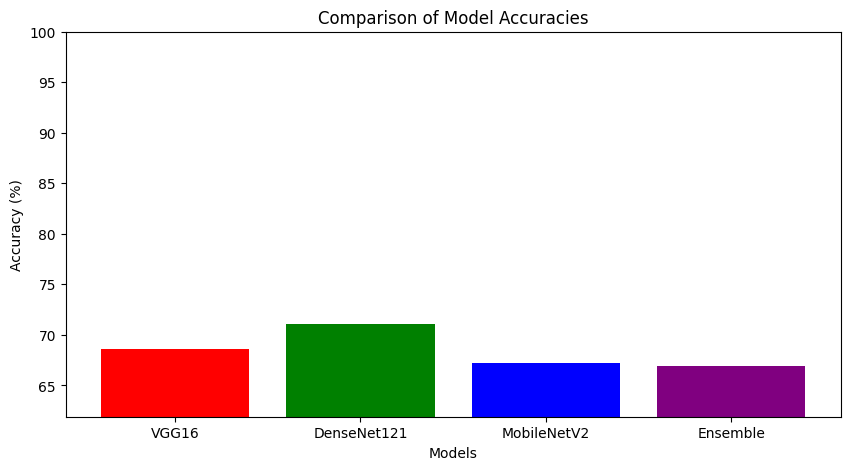

In [ ]:
import matplotlib.pyplot as plt

# Data to plot
labels = ['VGG16', 'DenseNet121', 'MobileNetV2', 'Ensemble']
accuracies = [vgg16_val_accuracy * 100, densenet_val_accuracy * 100, mobilenet_val_accuracy * 100, ensemble_accuracy * 100]

plt.figure(figsize=(10, 5))
plt.bar(labels, accuracies, color=['red', 'green', 'blue', 'purple'])
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Comparison of Model Accuracies')
plt.ylim([min(accuracies) - 5, 100])
plt.show()

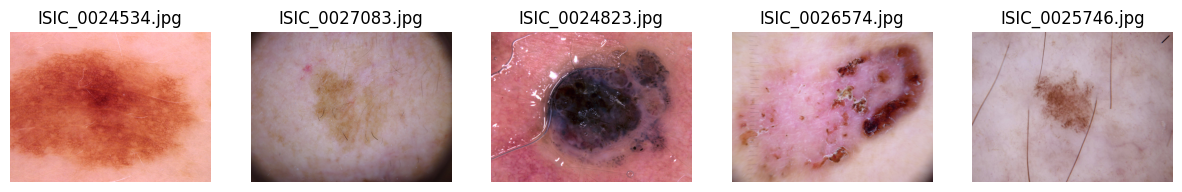

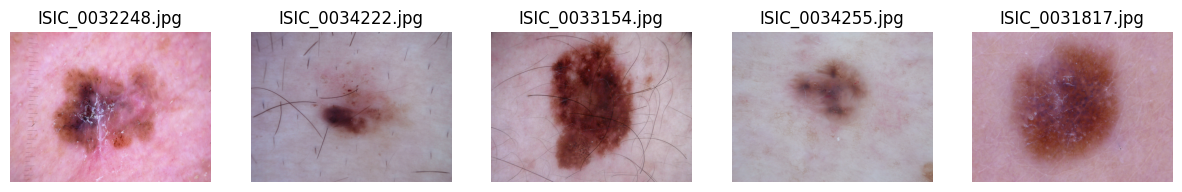

In [40]:
import matplotlib.pyplot as plt
from PIL import Image
import os

# Path to the directory containing the HAM10000 dataset
# dataset_dir = '/content/skin-cancer-mnist-ham10000'
dataset_dir1 = '/content/skin-cancer-mnist-ham10000/HAM10000_images_part_1'
dataset_dir2 = '/content/skin-cancer-mnist-ham10000/HAM10000_images_part_2'

# Function to display images
def display_images(directory, num_images=5):
    fig = plt.figure(figsize=(15, 5))
    image_files = os.listdir(directory)[:num_images]

    for i, image_file in enumerate(image_files, 1):
        image_path = os.path.join(directory, image_file)
        image = Image.open(image_path)

        # Display the image
        ax = fig.add_subplot(1, num_images, i)
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(image_file)

    plt.show()

# Display images from the HAM10000 dataset
# display_images(dataset_dir)
display_images(dataset_dir1)
display_images(dataset_dir2)

In [41]:
from tensorflow.keras.applications import VGG16, MobileNet, DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_model(base_model, num_classes):
    # Freeze the layers of the base model
    base_model.trainable = False

    # Adding a Global Average Pooling layer and a Dense output layer
    x = GlobalAveragePooling2D()(base_model.output)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Construct the final model
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Load the base pretrained models
num_classes = train_generator.num_classes  # This should match the number of classes in your dataset
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
mobilenet_base = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Build the models
vgg16_model = build_model(vgg16_base, num_classes)
mobilenet_model = build_model(mobilenet_base, num_classes)
densenet_model = build_model(densenet_base, num_classes)

In [43]:
# Train the models
vgg16_history = vgg16_model.fit(train_generator, validation_data=validation_generator, epochs=10, verbose=1)

FileNotFoundError: [Errno 2] No such file or directory: './skin-cancer-mnist-ham10000/train/nv/ISIC_0027271.jpg'

In [ ]:
model.save('vgg16_ham10000_trained.h5')

In [ ]:
!mv vgg16_ham10000.h5 /content/ensemble-pretrained-models

mv: 'vgg16_ham10000.h5' and '/content/ensemble-pretrained-models/vgg16_ham10000.h5' are the same file


In [ ]:
!rm -r /content/ensemble-pretrained-models

In [ ]:
# Change directory to the cloned repository
%cd /content/ensemble-pretrained-models

# Add the model file
!git add vgg16_ham10000.h5

# Commit the changes
!git commit -m "Add trained vgg16_ham10000.h5 model"

# Push changes to GitHub
!git push origin main

/content/ensemble-pretrained-models
On branch main
Your branch is ahead of 'origin/main' by 1 commit.
  (use "git push" to publish your local commits)

Changes not staged for commit:
  (use "git add/rm <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	deleted:    README.md

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	ensemble-pretrained-models/

no changes added to commit (use "git add" and/or "git commit -a")
fatal: could not read Username for 'https://github.com': No such device or address


In [ ]:
!git config --global user.email "dhananjayghosh7778@gmail.com"
!git config --global user.name "Dhananjay Ghosh"

In [ ]:
model.save('vgg16_ham10000_trained.keras')

In [39]:
mobilenet_history = mobilenet_model.fit(train_generator, validation_data=validation_generator, epochs=10, verbose=1)

FileNotFoundError: [Errno 2] No such file or directory: './skin-cancer-mnist-ham10000/train/nv/ISIC_0027271.jpg'

In [ ]:
densenet_history = densenet_model.fit(train_generator, validation_data=validation_generator, epochs=10, verbose=1)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Function to get predictions from a model
def get_predictions(model, generator):
    predictions = model.predict(generator)
    return predictions

# Get predictions from each base model
vgg16_preds = get_predictions(vgg16_model, validation_generator)
mobilenet_preds = get_predictions(mobilenet_model, validation_generator)
densenet_preds = get_predictions(densenet_model, validation_generator)

# Stack predictions as input features for the meta-model
stacked_preds = np.hstack((vgg16_preds, mobilenet_preds, densenet_preds))

# Get true class labels
true_labels = validation_generator.classes

# Split the stacked predictions for training the meta-model
X_train_stack, X_val_stack, y_train_stack, y_val_stack = train_test_split(
    stacked_preds, true_labels, test_size=0.2, random_state=42)

# Train the meta-model
meta_model = LogisticRegression(max_iter=1000)
meta_model.fit(X_train_stack, y_train_stack)

# Evaluate the meta-model on the validation set
meta_preds = meta_model.predict(X_val_stack)
meta_accuracy = accuracy_score(y_val_stack, meta_preds)
print(f"Meta-Model Accuracy: {meta

In [ ]:
# Plotting training history
def plot_history(histories, key='accuracy'):
    plt.figure(figsize=(15, 10))

    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                       '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
                 label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_', ' ').title())
    plt.legend()

    plt.xlim([0, max(history.epoch)])

# Assuming you have the history objects from the training
plot_history([('vgg16', vgg16_history),
              ('mobilenet', mobilenet_history),
              ('densenet', densenet_history)])